In [1]:
import pixelator
import anndata

import os
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
from pixelator import simple_aggregate

import scanpy as sc


/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/labs/nyosef/eitangr/mini

TODO: 
1. Understand best practice for order between normalization and filtering steps. Double normalization? (CLR/DSB + pp.normalize_total?)
2. Continue scanpy tutorials
3. Continue scvi tutorials


In [2]:
# Setup
DATA_DIR = Path('./datasets')

# Dataset: https://software.pixelgen.com/datasets/technote-mpx-v1-vs-v2
# We use only the V2 non stimulated cells
# FILENAMES = [
#     "Sample05_V2_PBMC_r1.layout.dataset.pxl",
#     "Sample06_V2_PBMC_r2.layout.dataset.pxl",
# ]

# COMBINED_FILENAME = "combined_resting_data.pxl"

# combined_path = DATA_DIR / COMBINED_FILENAME
# # if os.path.exists(combined_path):
# #     pg_data = pixelator.read(combined_path)
# baseurl = "https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/technote-v1-vs-v2-immunology-II"
# for filename in FILENAMES:
#     !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/{filename}"

# pg_data = pixelator.simple_aggregate(
#     ["resting_r1", "resting_r2", ], [pixelator.read(DATA_DIR / filename) for filename in FILENAMES]
# )
# pg_data.save(combined_path, force_overwrite=True)

# V2 kit (non stimulated cells)
pg_data_1 = pixelator.read(DATA_DIR / "Sample05_V2_PBMC_r1.layout.dataset.pxl")
# pg_data_1.adata.obs['sample'] = 'resting_r1'

pg_data_2 = pixelator.read(DATA_DIR / "Sample06_V2_PBMC_r2.layout.dataset.pxl")
# pg_data_1.adata.obs['sample'] = 'resting_r2'


adata = anndata.AnnData.concatenate(pg_data_1.adata, pg_data_2.adata, batch_key='sample', batch_categories=['resting_r1', 'resting_r2'])
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True, var_type='antibodies')
adata.write(filename=DATA_DIR / "Sample05_06_V2_PBMC.h5ad")
adata.obs

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)
/tmp/ipykernel_1093339/1967342146.py:33: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = anndata.AnnData.concatenate(pg_data_1.adata, pg_data_2.adata, batch_key='sample', batch_categories=['resting_r1', 'resting_r2'])


,pixels,a_pixels,b_pixels,antibodies,molecules,reads,mean_reads_per_molecule,median_reads_per_molecule,mean_b_pixels_per_a_pixel,median_b_pixels_per_a_pixel,...,mean_molecules_per_a_pixel,median_molecules_per_a_pixel,leiden,tau_type,tau,sample,n_antibodies_by_counts,log1p_n_antibodies_by_counts,total_counts,log1p_total_counts
component,,,,,,,,,,,,,,,,,,,,,
RCVCMP0000000-resting_r1,5833,3749,2084,79,35040,114108,3.256507,3.0,2.794345,2.0,...,9.346492,5.0,0,normal,0.935262,resting_r1,79,4.382027,35040,10.464274
RCVCMP0000001-resting_r1,4769,3338,1431,79,33399,107689,3.224318,3.0,2.933493,2.0,...,10.005692,5.0,1,normal,0.939779,resting_r1,79,4.382027,33399,10.416311
RCVCMP0000002-resting_r1,4227,2724,1503,78,34376,113349,3.297330,3.0,3.825624,3.0,...,12.619677,7.5,0,normal,0.922382,resting_r1,78,4.369448,34376,10.445143
RCVCMP0000004-resting_r1,3285,2159,1126,79,13859,42368,3.057075,3.0,2.352478,2.0,...,6.419176,3.0,2,normal,0.938652,resting_r1,79,4.382027,13859,9.536762
RCVCMP0000005-resting_r1,9958,6413,3545,79,43839,136302,3.109149,3.0,2.397318,2.0,...,6.835958,3.0,3,normal,0.945426,resting_r1,79,4.382027,43839,10.688302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCVCMP0003334-resting_r2,1131,666,465,76,3747,12032,3.211102,3.0,2.139640,2.0,...,5.626126,3.0,15,normal,0.910600,resting_r2,76,4.343805,3747,8.228978
RCVCMP0003513-resting_r2,1530,1032,498,76,12176,41360,3.396846,3.0,2.953488,2.0,...,11.798450,8.0,13,normal,0.971879,resting_r2,76,4.343805,12176,9.407304
RCVCMP0003847-resting_r2,563,376,187,71,4468,14986,3.354073,3.0,2.736702,2.0,...,11.882979,8.0,13,normal,0.982340,resting_r2,71,4.276666,4468,8.404920


## Abundance EDA

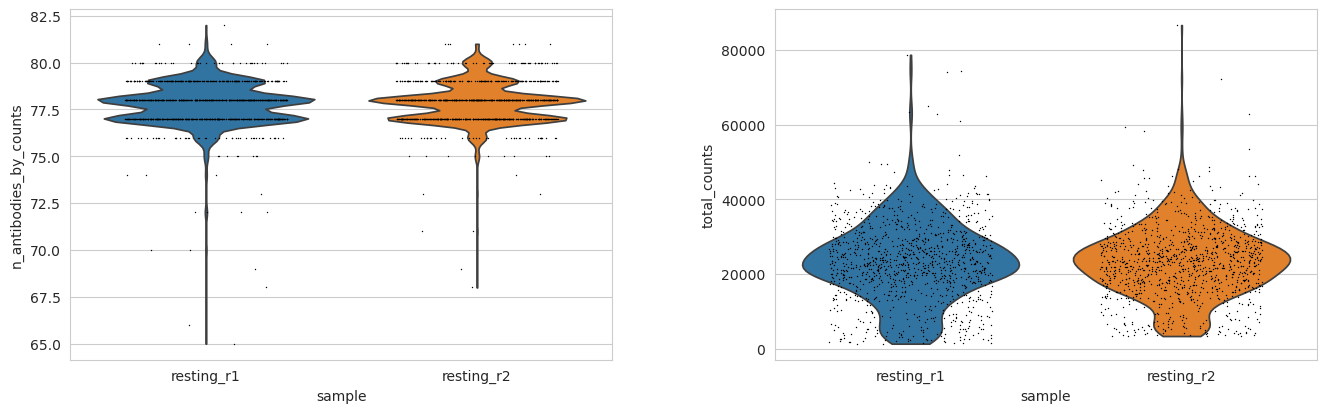

In [3]:
sc.pl.violin(
    adata,
    ["n_antibodies_by_counts", "total_counts",],
    groupby='sample',
    jitter=0.3,
    multi_panel=True,
)

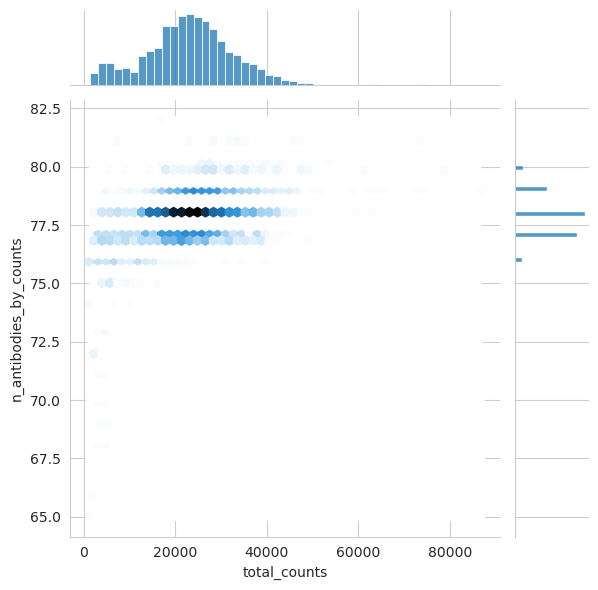

In [4]:
sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_antibodies_by_counts",
    kind="hex",
)

/tmp/ipykernel_1093339/144373203.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/pixelator/plot/__init__.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edge_rank_df["rank"] = edge_rank_df.groupby([group_by])["molecules"].rank(


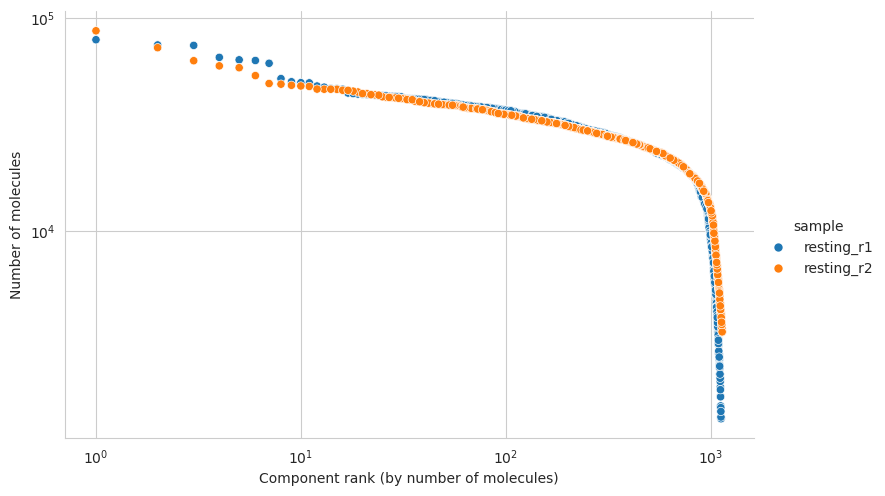

In [5]:
molecule_rank_df = adata.obs[["sample", "molecules"]].copy()
molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
    ascending=False, method="first"
)
fig, ax = molecule_rank_plot(molecule_rank_df, group_by="sample")

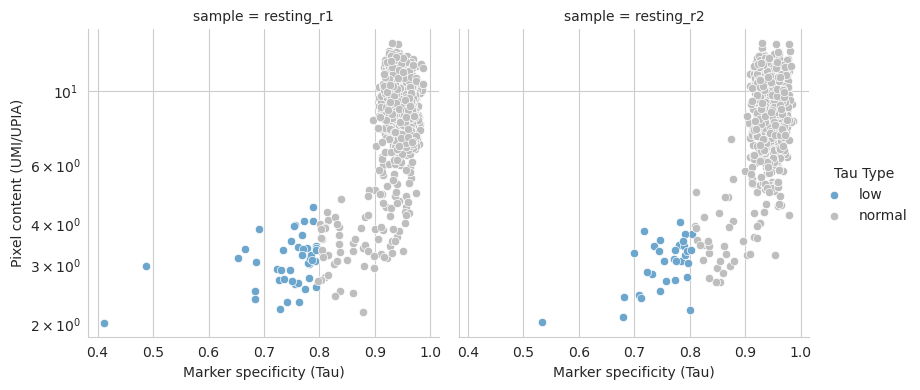

In [6]:
tau_metrics_df = adata.obs[["sample", "tau", "mean_molecules_per_a_pixel", "tau_type"]]
tau_metrics_df = tau_metrics_df.rename(columns={"mean_molecules_per_a_pixel": "umi_per_upia"})


fig, ax = scatter_umi_per_upia_vs_tau(tau_metrics_df, group_by="sample")

In [7]:
adata = adata[
    (adata.obs["molecules"] >= 10000)
    & (adata.obs["tau_type"] == "normal")
    & (adata.obs['a_pixels'] <= 10000)  # My change - removing a single outlier 
]

sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True, var_type='antibodies')
# os.remove(DATA_DIR/ "Sample06_V2_PBMC_r2.layout.dataset_FILTERED.pxl")
# pg_data.save(DATA_DIR/ "Sample06_V2_PBMC_r2.layout.dataset_FILTERED.pxl", force_overwrite=True)

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [8]:
# Single outlier with extreme measures of a_pixel
print((adata.obs['a_pixels'] > 20000).sum())
adata.obs = adata.obs.drop(adata.obs[adata.obs['a_pixels'] > 20000].index)

0


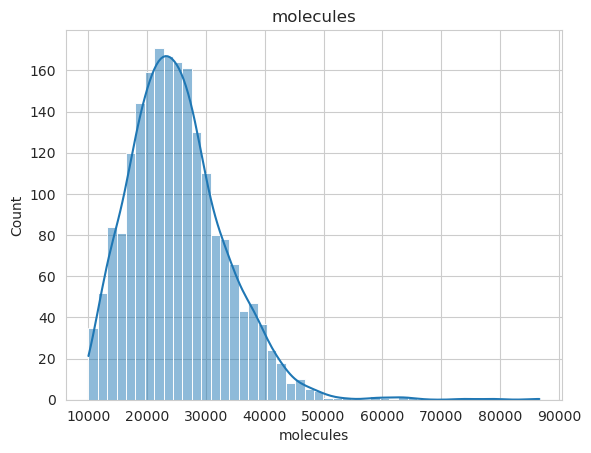

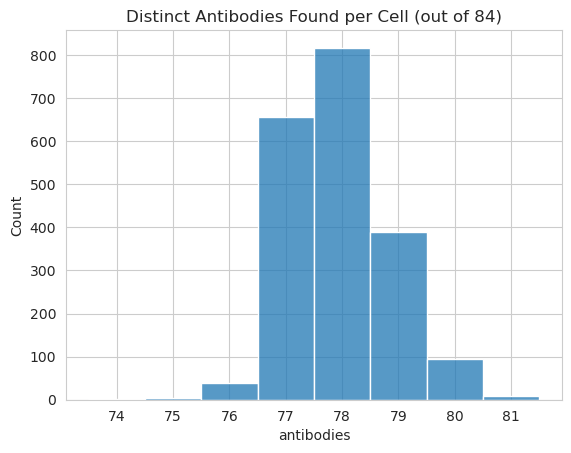

In [9]:
hist_vars = ['molecules', 'antibodies']

for var in hist_vars:
    fig, ax = plt.subplots(1)
    if var == 'antibodies':
        sns.histplot(adata.obs['antibodies'], ax=ax, discrete=True)
        ax.set_title('Distinct Antibodies Found per Cell (out of 84)')
        ax.set_xticks(list(range(adata.obs['antibodies'].min(), adata.obs['antibodies'].max() + 1)))
        continue
    sns.histplot(adata.obs[var], kde=True, ax=ax)
    ax.set_title(var)


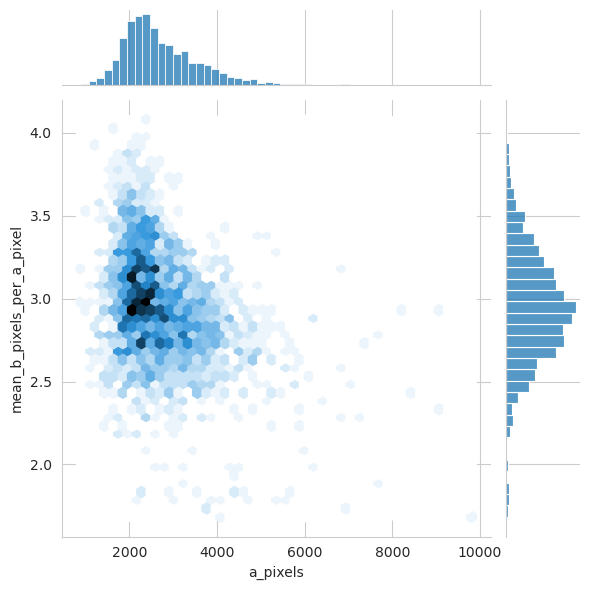

In [10]:
sns.jointplot(
    data=adata.obs,
    x="a_pixels",
    y="mean_b_pixels_per_a_pixel",
    kind="hex",
)

In [11]:
antibody_variation_df = adata.to_df().aggregate(['mean', 'std']).transpose()
antibody_variation_df['std/mean'] = antibody_variation_df['std'] / antibody_variation_df['mean']

Text(0.5, 1.0, 'Cells per antibody')

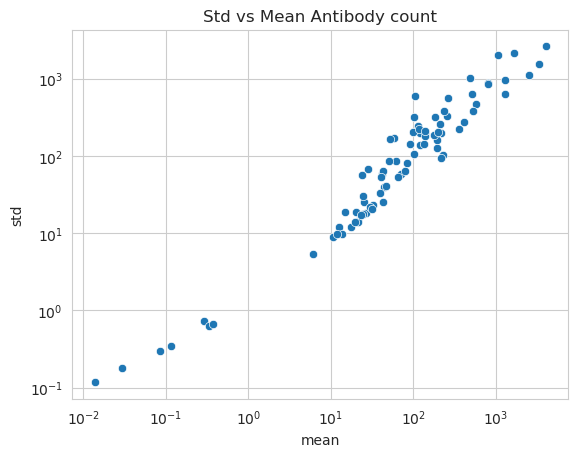

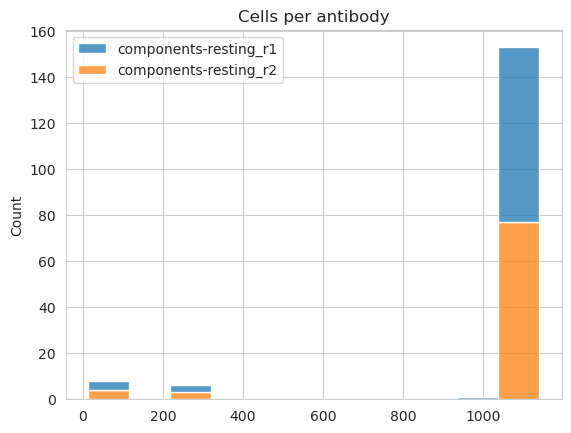

In [12]:
fig, ax = plt.subplots(1)
# sns.histplot(np.log10(adata.var['antibody_count']), ax=ax[0])
# ax[0].set_title('Log10 Total Antibody count')
sns.scatterplot(data=antibody_variation_df, x='mean', y='std')
ax.set_xscale('log')
ax.set_yscale('log')
# sns.histplot(np.log10(adata_df.mean(axis=0)), ax=ax)
ax.set_title('Std vs Mean Antibody count')

# fig, ax = plt.subplots(1)
# sns.histplot(np.log10(adata.var['components']), ax=ax, binwidth=0.25)
# ax.set_title('Log10 cells per antibody')

fig, ax = plt.subplots(1)
sns.histplot(adata.var[['components-resting_r1', 'components-resting_r2']], ax=ax, binwidth=100, multiple='stack')
ax.set_title('Cells per antibody')

# fig, ax = plt.subplots(1)
# antibody_variation = pg_data.adata.X.var(axis=0,)
# sns.histplot(np.log10(antibody_variation), ax=ax)
# ax.set_title('Log10 Antibody Count Variation (across cells)')

In [13]:
# antibody_variation_df.sort_values(by='mean', axis=0, ascending=False, inplace=True)
antibody_variation_df[antibody_variation_df['mean'] < 10].index

Index(['CD123', 'CD180', 'CD191', 'CD192', 'CD335', 'CD39', 'CD58', 'CD94'], dtype='object', name='marker')

Text(0.5, 1.0, 'Ab Pairs - Joint Cell Count (Abundance > 10)')

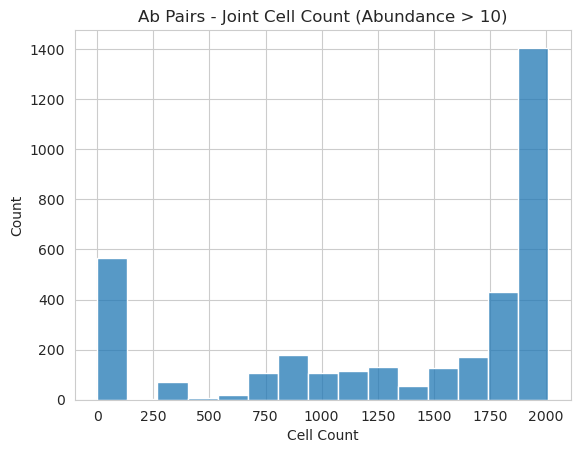

In [14]:
import itertools

adata_df = adata.to_df()
adata_corr = adata_df.corr()
n_antibodies = adata.X.shape[1]
antibody_pairs_names = list(itertools.combinations(adata.var_names, 2))
antibody_pair_count = pd.DataFrame(index=antibody_pairs_names, columns={'Cell Count': pd.Series(dtype=int), 'Corr': pd.Series(dtype=float)})
abundance_thresh = 10
for i, (ab_1, ab_2) in enumerate(antibody_pairs_names):
    name = (ab_1, ab_2)
    antibody_pair_count.at[name, 'Cell Count'] = len(adata_df[(adata_df[ab_1] > abundance_thresh) & (adata_df[ab_2] > abundance_thresh)])
    antibody_pair_count.at[name, 'Corr'] = adata_corr.loc[ab_1, ab_2]

# ax = sns.kdeplot(antibody_pair_count, x='Cell Count', y='Corr')
# ax.set_title('Ab Pairs - Correlation vs Joint Cell Count (Abundance > 10)')

ax = sns.histplot(antibody_pair_count['Cell Count'])
ax.set_title('Ab Pairs - Joint Cell Count (Abundance > 10)')

# protein_pair_count = pg_data.adata.X.copy()
# antibody_pair_count.sort_values(ascending=False).tail(10)


## DSB and CLR Normalization
DSB normalization should be taking care of "background noise" adding to the marker counts, due to non-specific binding.
However it does not work in all cases, it relies on having positive (=the marker should exist) and negative (=the marker should not exist) cell populations for each (?) marker.

In [15]:
from pixelator.analysis.normalization import dsb_normalize
from pixelator.statistics import clr_transformation

adata.layers['dsb'] = dsb_normalize(adata.to_df(), isotype_controls=["mIgG1", "mIgG2a", "mIgG2b"])
adata.layers['log1p'] = np.log1p(adata.to_df())
adata.layers['clr'] = clr_transformation(adata.to_df(), axis=1)
adata.layers['counts'] = adata.X.copy()

Text(0.5, 1.0, 'CLR')

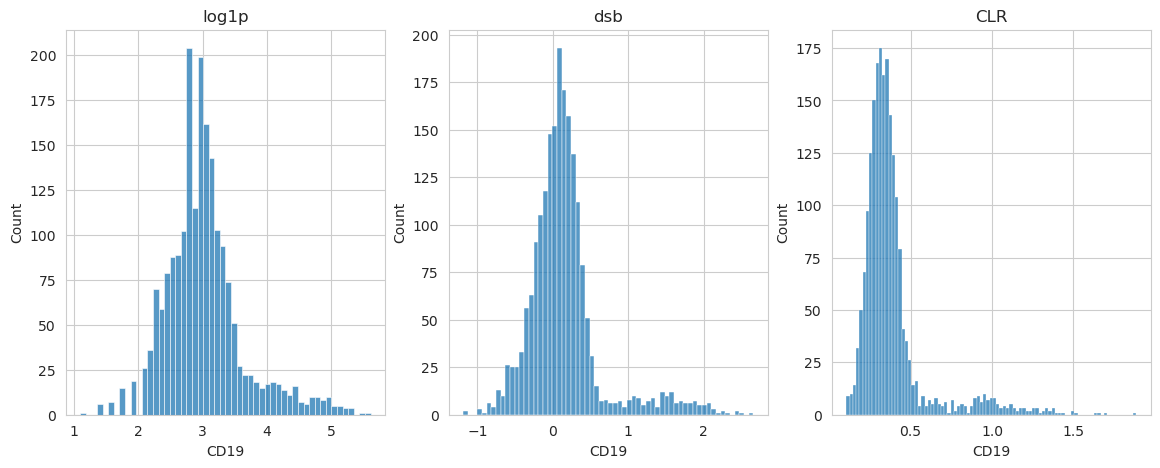

In [16]:
# CD19 marker
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
sns.histplot(data=adata.to_df('log1p'), x='CD19', ax=axes[0])
axes[0].set_title('log1p')
sns.histplot(data=adata.to_df('dsb'), x='CD19', ax=axes[1])
axes[1].set_title('dsb')
sns.histplot(data=adata.to_df('clr'), x='CD19', ax=axes[2])
axes[2].set_title('CLR')

## Key takeaways
1. A large majority of antibodies are present in almost all cells. However some antibodies are present in very low quantities with a mean abundance of less than 10: 'CD123', 'CD94', 'CD192', 'CD335', 'CD58', 'CD39', 'CD191', 'CD180'
2. Most cells have 10K-40K antibodies sequenced
3. Antibody abundance variance grows with mean
4. Antibody pairs could be informative even without spatial information

In [17]:
adata.X = adata.layers['clr'].copy()

In [18]:
# sc.pp.highly_variable_genes(adata, n_top_genes=20, batch_key='sample')
# sc.pl.highly_variable_genes(adata)


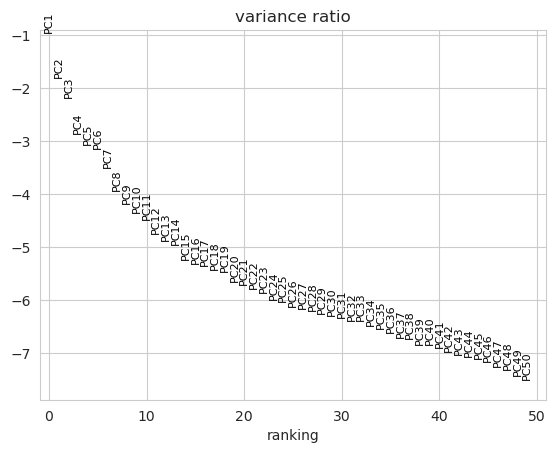

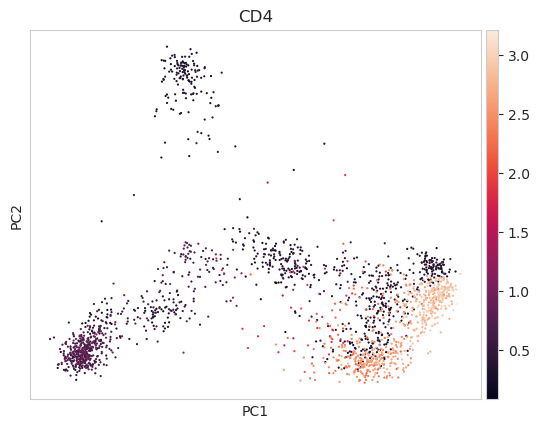

In [19]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
sc.pl.pca(
    adata,
    color=["CD4",],
    dimensions=[(0, 1)],
    size=10,
)

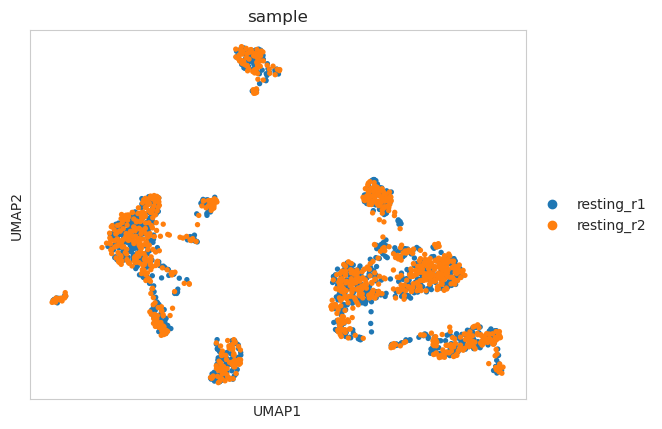

In [20]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='sample')

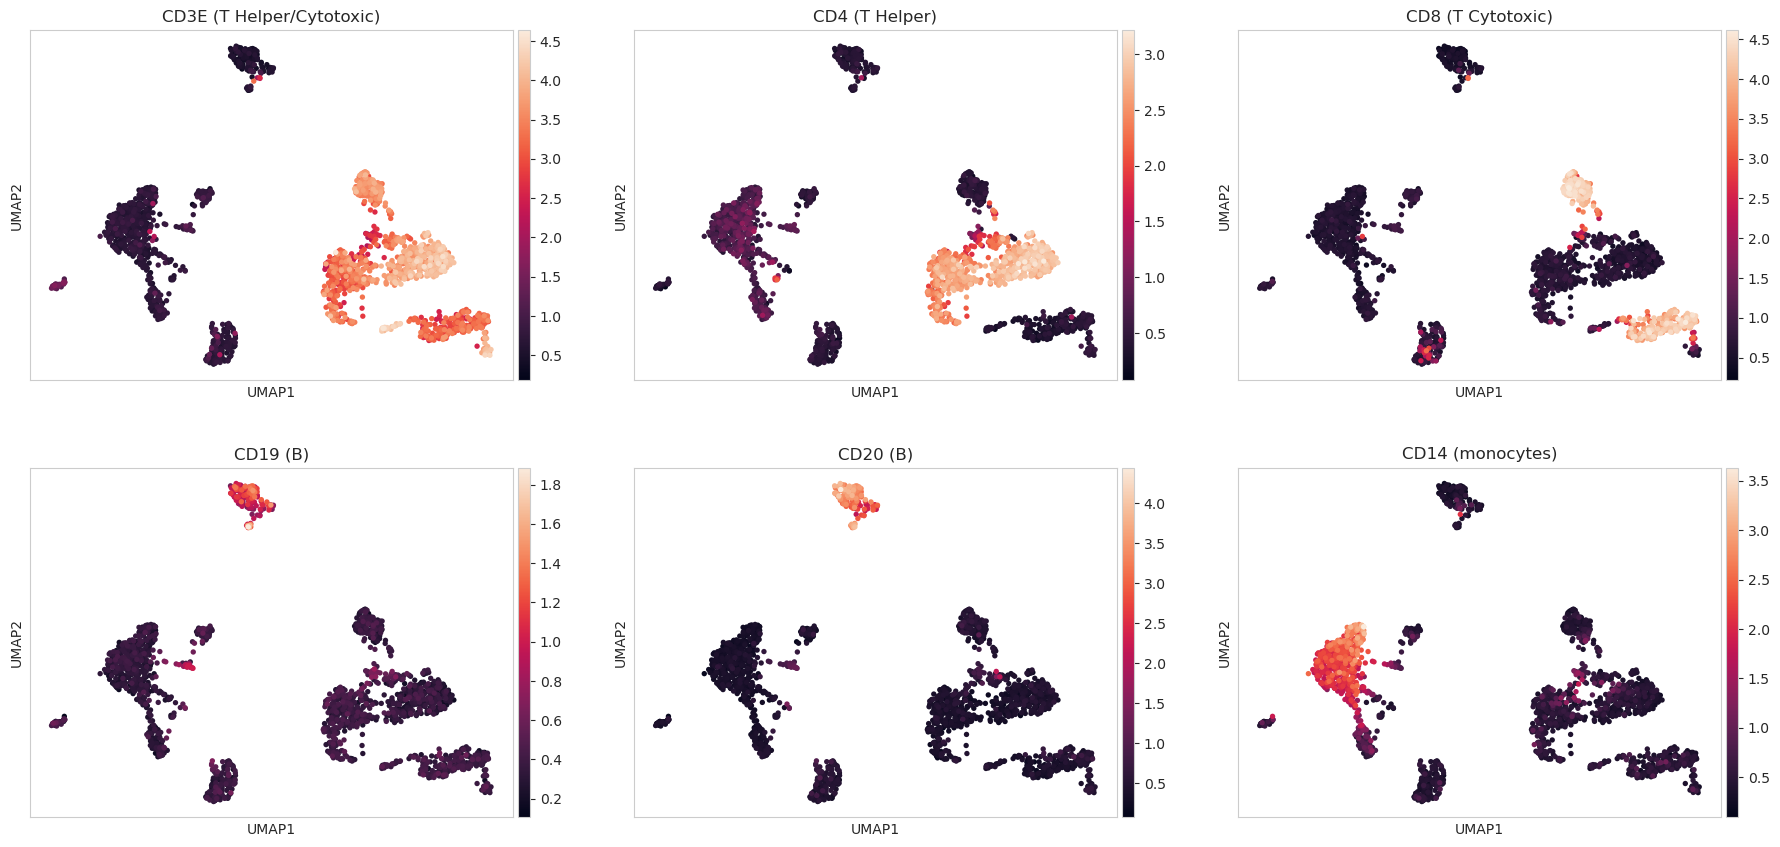

In [21]:
markers_of_interest = ["CD3E", "CD4", "CD8", "CD19", "CD20", "CD14"]
titles = ["CD3E (T Helper/Cytotoxic)", "CD4 (T Helper)", "CD8 (T Cytotoxic)", "CD19 (B)", "CD20 (B)", "CD14 (monocytes)"]
sc.pl.umap(adata, color=markers_of_interest, ncols=3, layer='clr', title=titles)

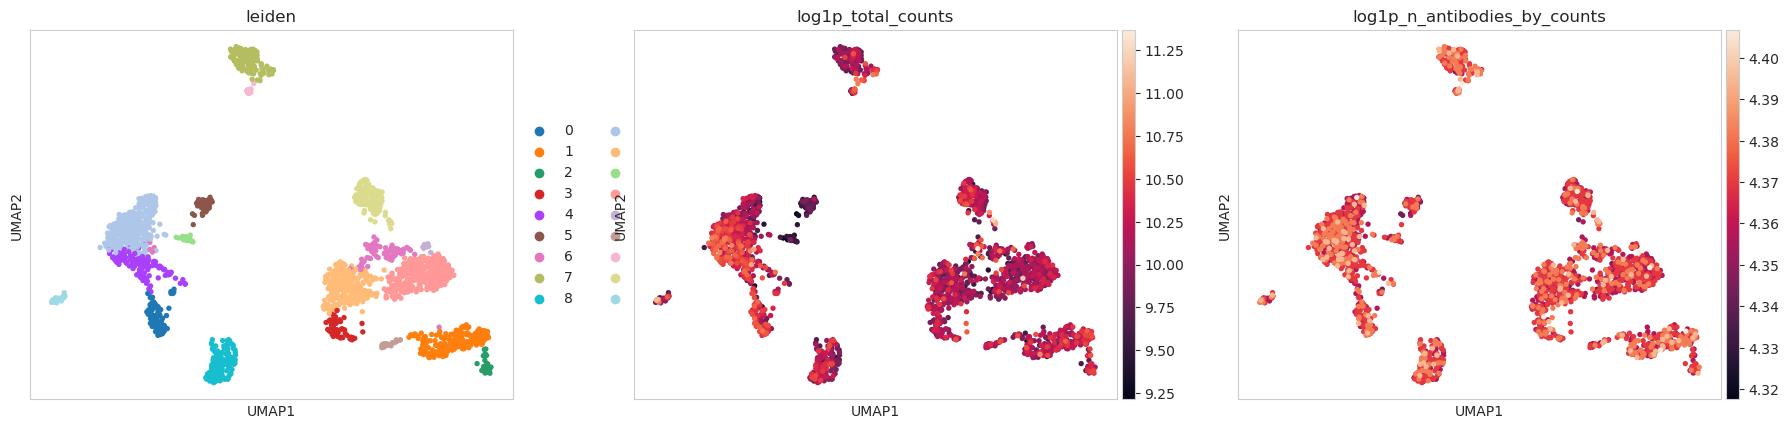

In [22]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
sc.pl.umap(adata, color=['leiden', 'log1p_total_counts', 'log1p_n_antibodies_by_counts'], ncols=3)

categories: 0, 1, 2, etc.
var_group_labels: 0, 1, 2, etc.


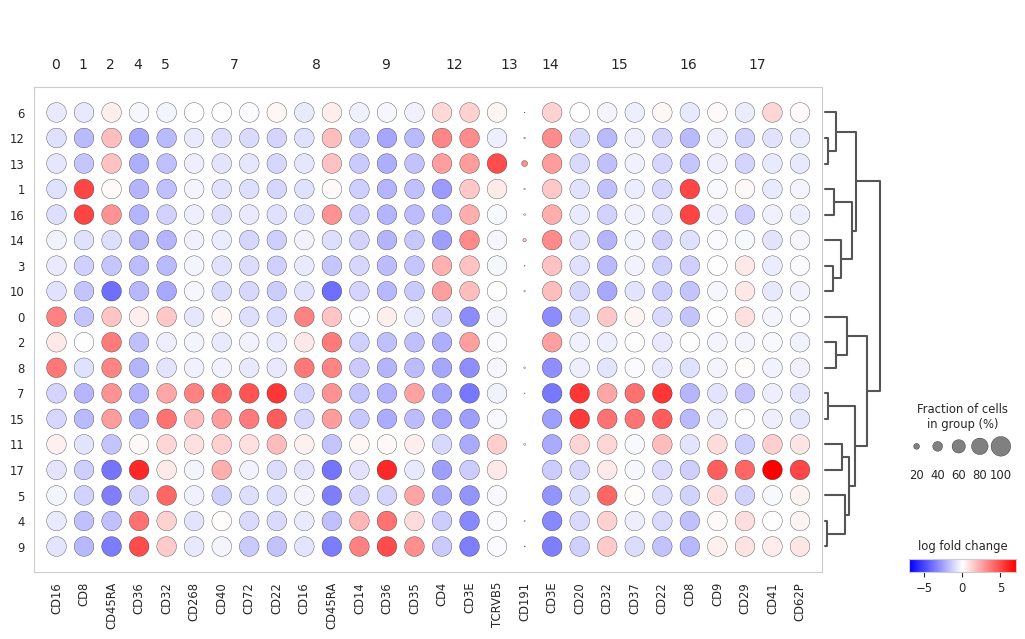

In [23]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, values_to_plot="logfoldchanges",
    min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap="bwr",)


In [24]:
adata.write(filename=DATA_DIR / "Sample05_06_V2_PBMC_FILTERED_NORMALIZED.h5ad")

## Graph Properties EDA

Reminder: each cell is a bipartite graph with left-side nodes being A pixels and right-side nodes being B pixels. Each edge between two pixels has a UMI that siginifies that that molecule was hybridized by both of those pixels, i.e. is in both of those small spatial areas.

Each cell has around 2000 A nodes and 1000 B nodes. Each A node has around 9 edges, to 3 distinct B nodes. Each B node is connected to around 6 distinct A nodes.

Each edge corresponds to a molecule, therefore # molecules = # edges which is centered around 20,000 as we saw in the Abundance EDA.

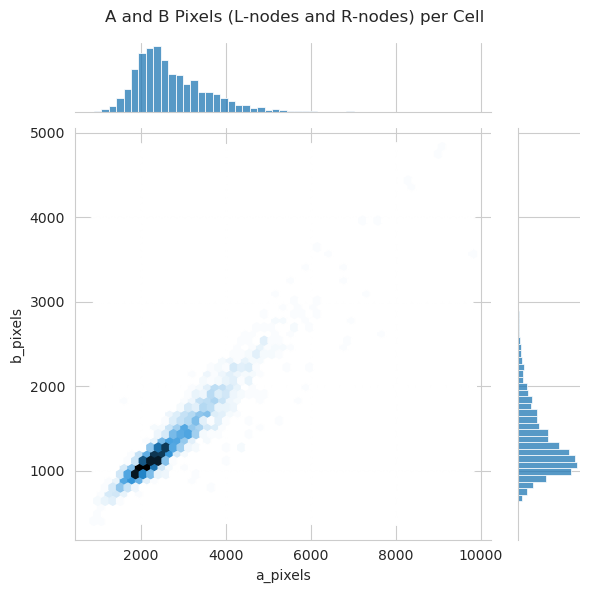

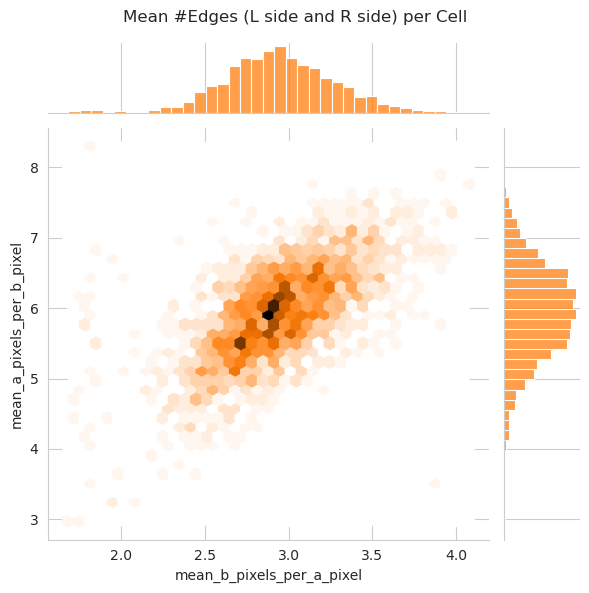

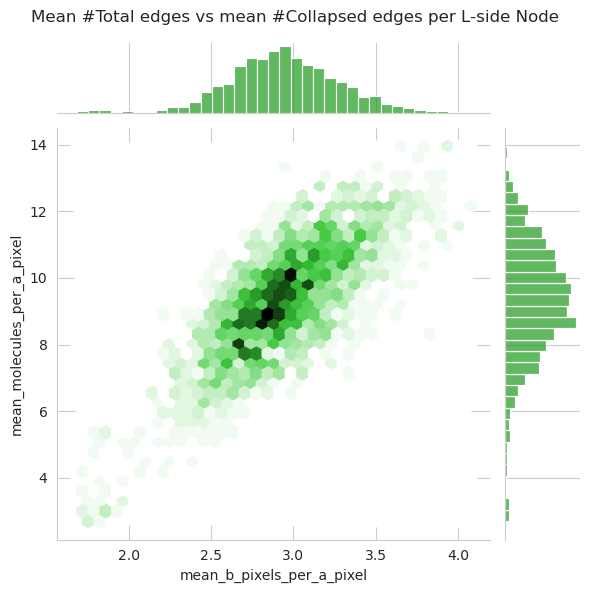

In [25]:
jg  = sns.jointplot(adata.obs, x='a_pixels', y='b_pixels', kind='hex',)
jg.figure.suptitle('A and B Pixels (L-nodes and R-nodes) per Cell')
jg.figure.tight_layout()

jg  = sns.jointplot(adata.obs, x='mean_b_pixels_per_a_pixel', y='mean_a_pixels_per_b_pixel', kind='hex', color=sns.color_palette()[1])
jg.figure.suptitle('Mean #Edges (L side and R side) per Cell')
jg.figure.tight_layout()

jg  = sns.jointplot(adata.obs, x='mean_b_pixels_per_a_pixel', y='mean_molecules_per_a_pixel', kind='hex', color=sns.color_palette()[2])
jg.figure.suptitle('Mean #Total edges vs mean #Collapsed edges per L-side Node')
jg.figure.tight_layout()


The data comes with colocalization scores per pairs of markers per cell, calculated in two ways:
1. A Pearson's correlation between counts of the two markers in small areas, and a Z score calculated based on the r value
2. Jaccard index, which measures similarity between all neighborhoods containing each marker (And a Z score for Jaccard as well).

Text(0.5, 1.0, "Pearson's r z score, mean across cells")

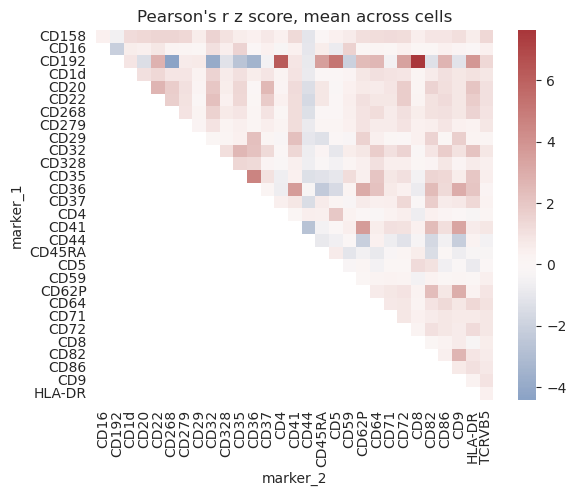

In [ ]:
# Rank markers by variability
variable_markers = sc.pp.highly_variable_genes(adata, layer='counts', n_top_genes=30, flavor='seurat_v3', inplace=False)
# variable_markers.sort_values(by='highly_variable_rank', ascending=True, inplace=True)
# print(variable_markers.reset_index().head(5))
# top_markers = variable_markers.index[:15]
# # print(top_markers)
coloc = pg_data_1.colocalization.copy()
coloc = coloc.join(variable_markers['highly_variable'], on='marker_1', validate='many_to_one')
coloc.rename(columns={'highly_variable': 'marker_1_highly_variable'}, inplace=True)
coloc = coloc.join(variable_markers['highly_variable'], on='marker_2', validate='many_to_one')
coloc.rename(columns={'highly_variable': 'marker_2_highly_variable'}, inplace=True)
coloc['highly_variable_pair'] = coloc['marker_1_highly_variable'] & coloc['marker_2_highly_variable']

filtered_coloc = coloc[coloc['highly_variable_pair']]

# grid = sns.catplot(
#     row='marker_1', col='marker_2', data=filtered_coloc, y='pearson_z', kind='violin', height=1, aspect=1, facet_kws=dict(ylim=(-10, 10))
# )
# g = sns.FacetGrid(data=filtered_coloc, row='marker_1', col="marker_2", sharey=True, height=1, aspect=1)
# g.map(sns.violinplot, y='pearson_z', orient='v')

# sns.violinplot(filtered_coloc, )
# filtered_coloc.head(5)
# pivoted_coloc
# ax = sc.pl.stacked_violin()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
pivoted_coloc = pd.pivot_table(filtered_coloc, values='pearson_z', index='marker_1', columns='marker_2', aggfunc='mean')
sns.heatmap(pivoted_coloc, center=0, cmap=sns.color_palette("vlag", as_cmap=True), xticklabels=True, yticklabels=True, ax=ax[0])
pivoted_coloc = pd.pivot_table(filtered_coloc, values='jaccard_z', index='marker_1', columns='marker_2', aggfunc='mean')
sns.heatmap(pivoted_coloc, center=0, cmap=sns.color_palette("vlag", as_cmap=True), xticklabels=True, yticklabels=True, ax=ax[1])
ax.set_title("Pearson's r z score, mean across cells")
# pg_data_1.colocalization.groupby(['marker_1', 'marker_2']).aggregate('')

<Axes: xlabel='pearson_z', ylabel='jaccard_z'>

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


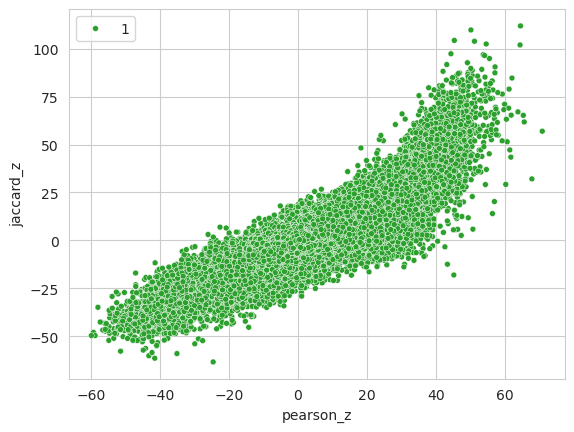

In [ ]:
# sns.scatterplot(coloc, x='pearson_z', y='jaccard_z', color=sns.color_palette()[2], size=1)

In [28]:
pg_data_1.colocalization.head(5)

,marker_1,marker_2,pearson,pearson_mean,pearson_stdev,pearson_z,pearson_p_value,pearson_p_value_adjusted,jaccard,jaccard_mean,jaccard_stdev,jaccard_z,jaccard_p_value,jaccard_p_value_adjusted,component
0,ACTB,B2M,-0.004562,-0.012738,0.025900,0.315672,3.761257e-01,3.975680e-01,0.238681,0.257546,0.008556,-2.204776,0.013735,0.024148,RCVCMP0000000
1,ACTB,CD102,-0.139138,-0.001331,0.022208,-6.205428,2.727414e-10,1.339170e-09,0.241310,0.258330,0.008305,-2.049466,0.020208,0.033899,RCVCMP0000000
2,B2M,CD102,-0.207174,-0.040284,0.027302,-6.112788,4.895280e-10,2.333059e-09,0.271056,0.296720,0.008591,-2.987515,0.001406,0.003181,RCVCMP0000000
3,ACTB,CD11a,-0.080322,-0.005232,0.024710,-3.038852,1.187408e-03,2.290011e-03,0.245492,0.256245,0.007787,-1.380914,0.083653,0.116167,RCVCMP0000000
4,B2M,CD11a,0.033532,-0.045293,0.019437,4.055448,2.501919e-05,6.373526e-05,0.326618,0.297709,0.008697,3.324091,0.000444,0.001126,RCVCMP0000000


In [29]:
# Not merging for now as it is very slow

# edgelist_1 = pg_data_1.edgelist
# edgelist_1['sample'] = 'resting_r1'
# edgelist_2 = pg_data_2.edgelist
# edgelist_2['sample'] = 'resting_r2'

# combined_edgelist = pd.concat([edgelist_1, edgelist_2], axis=0, ignore_index=True)
# combined_edgelist['orig_component'] = combined_edgelist['component'].copy()
# combined_edgelist['component'] = [f'{component}-{sample}' for (component, sample) in zip(combined_edgelist['orig_component'], combined_edgelist['sample'])]
# combined_edgelist

In [30]:
# # Minimal crashing code

# DATA_DIR = Path('./datasets')

# baseurl = "https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/technote-v1-vs-v2-immunology-II"

# # !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/Sample05_V2_PBMC_r1.layout.dataset.pxl"
# # !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/Sample06_V2_PBMC_r2.layout.dataset.pxl"
# # !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/Sample07_V2_PHA_PBMC_r1.layout.dataset.pxl"
# # !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/Sample08_V2_PHA_PBMC_r2.layout.dataset.pxl"

# paths = [
#     DATA_DIR / "Sample05_V2_PBMC_r1.layout.dataset.pxl",
#     DATA_DIR / "Sample06_V2_PBMC_r2.layout.dataset.pxl",
#     # DATA_DIR / "Sample07_V2_PHA_PBMC_r1.layout.dataset.pxl",
#     # DATA_DIR / "Sample08_V2_PHA_PBMC_r2.layout.dataset.pxl",
# ]

# names = [ "resting_r1", 
#          "resting_r2", 
#         #  "stimulated_r1", 
#         #  "stimulated_r2"
#         ]

# pg_data_combined = simple_aggregate(
#     names, [pixelator.read(path) for path in paths]
# )
# pg_data_combined

In [31]:
# from pathlib import Path
# import pixelator
# from pixelator import simple_aggregate


# DATA_DIR = Path('./datasets')
# FILENAMES = [
#     "Sample05_V2_PBMC_r1.layout.dataset.pxl",
#     "Sample06_V2_PBMC_r2.layout.dataset.pxl",
# ]

# COMBINED_FILENAME = "combined_resting_data.pxl"

# combined_path = DATA_DIR / COMBINED_FILENAME
# baseurl = "https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/technote-v1-vs-v2-immunology-II"
# for filename in FILENAMES:
#     !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/{filename}"

# pg_data = pixelator.simple_aggregate(
#     ["resting_r1", "resting_r2", ], [pixelator.read(DATA_DIR / filename) for filename in FILENAMES]
# )
# pg_data.save(combined_path, force_overwrite=True)